# **군집**

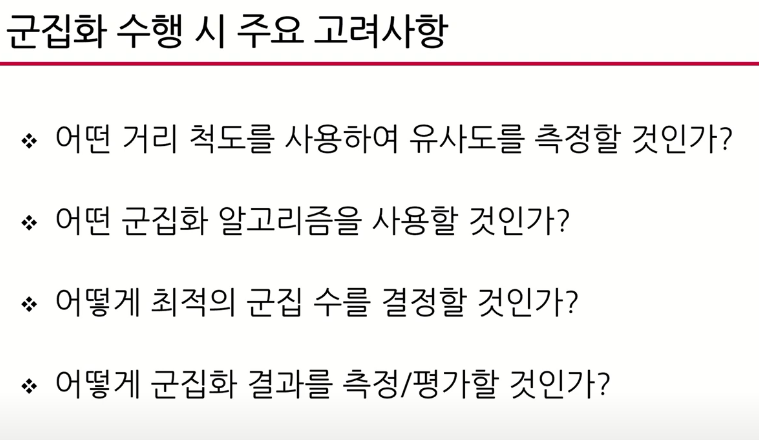

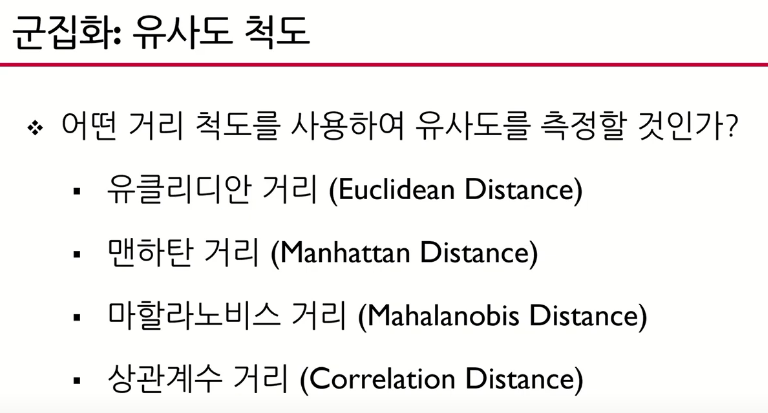

## **1. 공통 모듈 불러오기**

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import silhouette_score 
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline

import seaborn as sns; sns.set()

## **2. 데이터 불러오기**

In [ ]:
# Generate some data
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

plt.scatter(X[:, 0], X[:, 1], s = 30, cmap='viridis')
# https://frhyme.github.io/python-lib/matplotlib_extracting_color_from_cmap/

## **3. K-means 복습**

- scipy.spatial.distance.cdist(XA, XB, metric='euclidean', *, out=None, **kwargs)
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
    - metric (거리 계산 알고리즘)
        1. 유클리디안‘euclidean’
        2. 맨하탄 거리‘cityblock’
        3. 마할라노비스‘mahalanobis’
        4. 상관계수 ‘correlation’
        5. 'braycurtis’, ‘canberra’, ‘chebyshev’,  ‘cosine’, ‘dice’,  ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulsinski’, , ‘matching’, ‘minkowski’,‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘wminkowski’, ‘yule’



In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [ ]:
import sklearn.metrics as metrics
from scipy.spatial.distance import cdist

# plot
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # cluster 중심 값
    centers = kmeans.cluster_centers_

    # 유클리디안(기본값) 거리 계산 / 각 군집의 중심값으로부터 가장 멀리 떨어진 거리
    radii = [cdist(X[labels == i], [center], metric='euclidean').max() for i, center in enumerate(centers)]

    # 군집 중심 및 거리로 plot
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

### 3-1. 최적 군집 개수 찾기
1. 실루엣 계수
2. 덴드로그램

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit(X).predict(X)

score_kmeans_s = silhouette_score(X, labels, metric='euclidean')
print(score_kmeans_s)

In [ ]:
# Create empty list
S=[]

# Range of clusters to try (2 to 20)
K = range(2,21)

# Select data for clustering model

for k in K:
    # Set the model and its parameters
    kmeans = KMeans(k, random_state=0)
    # Fit the model 
    labels = kmeans.fit(X).predict(X)
    # Calculate Silhoutte Score and append to a list
    S.append(silhouette_score(X, labels, metric='euclidean'))

# Plot the resulting Silhouette scores on a graph
plt.figsize=(16,8)
plt.plot(K, S, 'bo-', color='black')
plt.xlabel('n_components')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
# Silhouette

n_components = np.arange(2, 21)
models = [KMeans(n, random_state=0).fit(X) for n in n_components]

plt.plot(n_components, [silhouette_score(X, m.predict(X), metric='euclidean') for m in models], label = 'silhouette')

plt.legend(loc='best')
plt.xlabel('n_components');

In [ ]:
# Dendogram for Heirarchical Clustering

import scipy.cluster.hierarchy as shc
from matplotlib import pyplot

pyplot.figure(figsize=(12, 8))  
pyplot.title("Dendrograms")

dend = shc.dendrogram(shc.linkage(X, method='ward'))

### 3-2. K-means의 약점

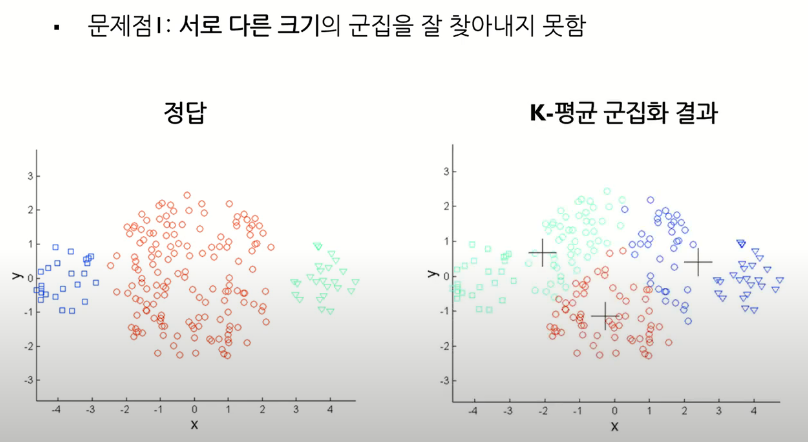

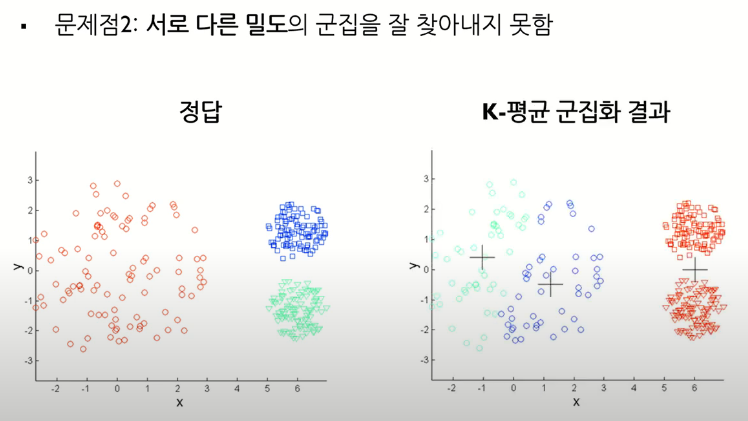

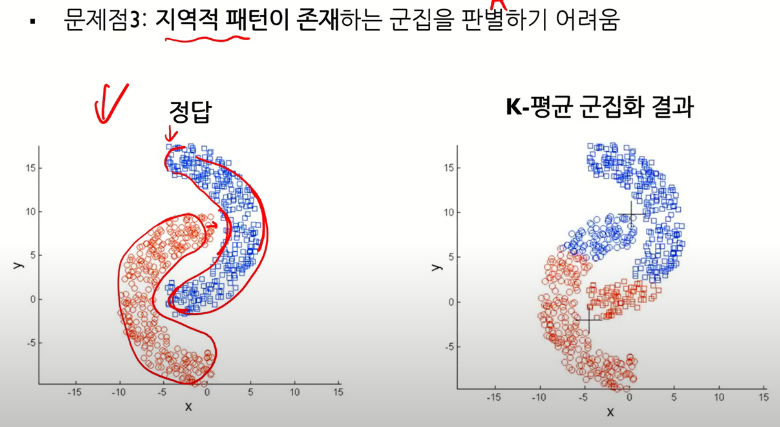

In [ ]:
# 랜덤 난수 생성
rng = np.random.RandomState(13)

# X와 랜덤난수 행렬 (2,2) 곱하기
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

In [ ]:
# Silhouette

n_components = np.arange(2, 11)
models = [KMeans(n, random_state=0).fit(X_stretched) for n in n_components]

plt.plot(n_components, [silhouette_score(X_stretched, m.predict(X_stretched), metric='euclidean') for m in models], label = 'silhouette')

plt.legend(loc='best')
plt.xlabel('n_components');

## **4. GMM(Gaussian Mixture Model)**

https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html?highlight=gaussian%20mixture#examples-using-sklearn-mixture-gaussianmixture

GMM 이론 설명 

https://angeloyeo.github.io/2021/02/08/GMM_and_EM.html

label이 주어져있지 않은 데이터에 대해 데이터셋은 정규분포를 이룰 것이라 가정하고 clustering을 수행

- EM 알고리즘은 기본적으로 Unsupervised learning에 주로 사용되는 알고리즘이다. 그래서 Clustering에 사용되기도 한다. EM 알고리즘은 크게 E-step과 M-step 2가지 단계로 나누어질 수 있는데 결론부터 말하면 이 E-step과 M-step을 반복하면서(iterative) 최적의 파라미터값을 찾아가는 흐름이다. 

    - E-step : 주어진 임의의 파라미터 초기값에서 Likelihood와 최대한 근사한 likelihood값을 계산한다.

    - M-step : E-step에서 계산된 likelihood를 최대화(maximize)하는 새로운 파라미터값을 얻는다.

    - 위 2단계를 파라미터값이 크게변하지 않을 때까지 계속적으로 반복한다.

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [ ]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

In [ ]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

In [ ]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [ ]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X)

In [ ]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=0)
plot_gmm(gmm, X_stretched)

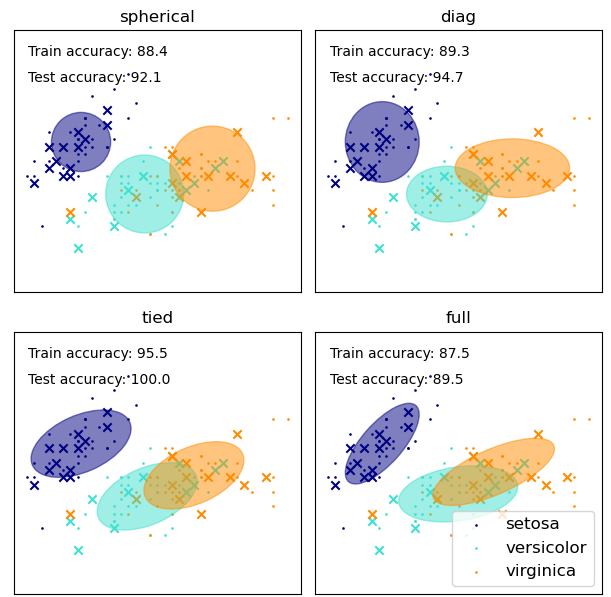

### **4-1. 최적 군집 개수 찾기**

- 실루엣 점수는 사용 할 수 없음 
    - 군집이 타원형, 크기가 다를 때 안정적이지 못함
- BIC(Bayesian Information Criterion), AIC(Akaike Information Criterion) 사용
    - BIC = log(m)p - 2log(L)
    - AIC = 2p - 2log(L)
    - m : 샘플 개수
    - p : 모델이 학습할 파라미터 개수
    - L : 모델의 기능도 함수(likelihood function) 최대값



In [ ]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X)

In [ ]:
# BIC, AIC

n_components = np.arange(1, 11)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [ ]:
# Silhouette

n_components = np.arange(2, 11)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in n_components]

plt.plot(n_components, [silhouette_score(X, m.predict(X), metric='euclidean') for m in models], label = 'silhouette')

plt.legend(loc='best')
plt.xlabel('n_components');

### **4-2. GMM을 통한 Density estimation**

In [ ]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)

plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

In [ ]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

In [ ]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

In [ ]:
# BIC, AIC

n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon) for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [ ]:
gmm7 = GaussianMixture(n_components=7, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

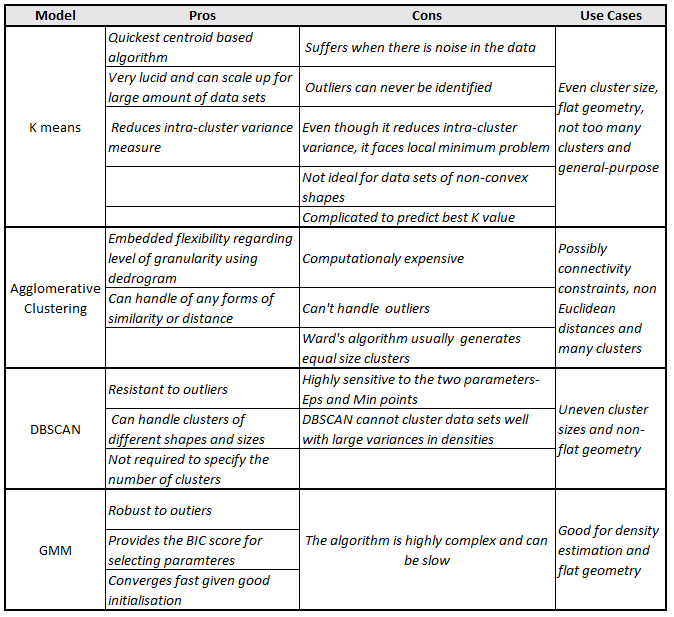

## **5. 출처**

실습 자료
1. https://youtu.be/_U7AUJqzlJs
2. https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

이론 자료
1. https://angeloyeo.github.io/2021/02/08/GMM_and_EM.html
2. https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
3. https://towardsdatascience.com/k-means-dbscan-gmm-agglomerative-clustering-mastering-the-popular-models-in-a-segmentation-c891a3818e29

# **차원축소**

- PCA의 경우 정방 행렬(열의 크기가 같은 행렬)만을 고유 벡터로 분해 가능함
- SVD는 행과 열의 크기가 다른 경우에도 적용 가능

## **1. SVD**

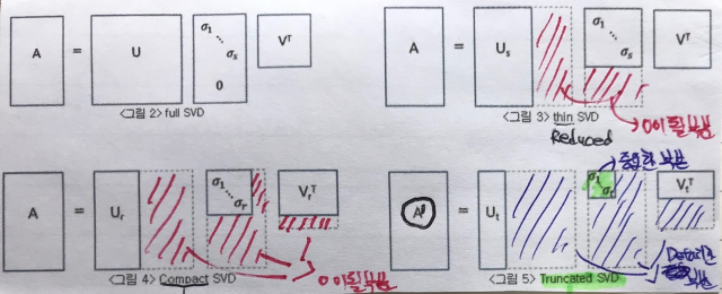

In [ ]:
# 모듈 불러오기
import numpy as np
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
plt.style.use("default")
%matplotlib inline

# 데이터셋 불러오기
iris = load_iris()
iris_ftrs = iris.data

# 2개의 주요 component로 TruncatedSVD 변환
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(iris_ftrs)
iris_tsvd = tsvd.transform(iris_ftrs)

# Scatter plot 2차원으로 TruncatedSVD 변환 된 데이터 표현. 품종은 색깔로 구분
plt.scatter(x=iris_tsvd[:,0], y= iris_tsvd[:,1], c= iris.target)
plt.xlabel('TruncatedSVD Component 1')
plt.ylabel('TruncatedSVD Component 2')

In [ ]:
from sklearn.preprocessing import StandardScaler

# iris 데이터를 StandardScaler로 변환
scaler = StandardScaler()
iris_scaled = scaler.fit_transform(iris_ftrs)

# 스케일링된 데이터를 기반으로 TruncatedSVD 변환 수행 
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(iris_scaled)
iris_tsvd = tsvd.transform(iris_scaled)

# 스케일링된 데이터를 기반으로 PCA 변환 수행 
pca = PCA(n_components=2)
pca.fit(iris_scaled)
iris_pca = pca.transform(iris_scaled)

# TruncatedSVD 변환 데이터를 왼쪽에, PCA변환 데이터를 오른쪽에 표현 
fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
ax1.scatter(x=iris_tsvd[:,0], y= iris_tsvd[:,1], c= iris.target)
ax2.scatter(x=iris_pca[:,0], y= iris_pca[:,1], c= iris.target)
ax1.set_title('Truncated SVD Transformed')
ax2.set_title('PCA Transformed')

In [ ]:
print((iris_pca - iris_tsvd).mean())
print((pca.components_ - tsvd.components_).mean())

## **2. NMF**

- Truncated SVD와 같이 낮은 랭크를 통한 행렬 근사(Low-Rank Approximation) 방식의 변형
- NMF는 원본 행렬 내의 모든 원소 값이 모두 양수(0 이상)라는게 보장되면 다음과 같이 두개으 기반 양수 행렬로 분해될수 있는 기법
- SVD와 유사하게 차원축소를 통한 잠재 요소 도출로 이미지 변환 및 압축, 텍스트의 도픽 도출 등에 사용되어짐

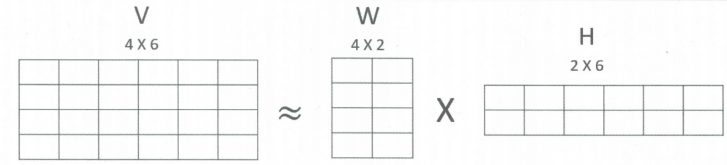

In [ ]:
from sklearn.decomposition import NMF
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

iris = load_iris()
iris_ftrs = iris.data
nmf = NMF(n_components=2)

nmf.fit(iris_ftrs)
iris_nmf = nmf.transform(iris_ftrs)

plt.scatter(x=iris_nmf[:,0], y= iris_nmf[:,1], c= iris.target)
plt.xlabel('NMF Component 1')
plt.ylabel('NMF Component 2')


## **3. t-sne**

In [ ]:
# load library

from sklearn.datasets import load_digits
import matplotlib
import matplotlib.pyplot as plt

# matplotlib 설정
matplotlib.rc('font', family='AppleGothic') # 한글 출력
plt.rcParams['axes.unicode_minus'] = False # 축 - 설정

# data load
digits = load_digits()

# subplot 객체 생성

fig, axes = plt.subplots(2, 5, #  subplot객체(2x5)를 axes에 할당
                         subplot_kw={'xticks':(), 'yticks':()}) # subplot 축 눈금 해제

for ax, img in zip(axes.ravel(), digits.images): # axes.ravel()과 digits.images를 하나씩 할당
    ax.imshow(img)

plt.gray() # 그래프 흑백
plt.show() # 그래프 출력

In [ ]:
### 처음 두 개의 주성분을 이용해 그래프를 그리고 각 샘플을 해당하는 클래스의 숫자로

from sklearn.decomposition import PCA

# PCA 모델을 생성
pca = PCA(n_components=2) # 주성분 갯수
pca.fit(digits.data) # PCA 적용

# 처음 두 개의 주성분으로 숫자 데이터를 변환
digits_pca = pca.transform(digits.data) # PCA를 데이터에 적용
colors = ['#476A2A', '#7851B8', '#BD3430', '#4A2D4E', '#875525', '#A83683', '#4E655E', '#853541', '#3A3120', '#535D8E']

for i in range(len(digits.data)): # digits.data의 길이까지 정수 갯수
    # 숫자 텍스트를 이용해 산점도 그리기
    plt.text(digits_pca[i, 0], digits_pca[i, 1], str(digits.target[i]), # x, y, 그룹; str은 문자로 변환
             color=colors[digits.target[i]], # 산점도 색상
             fontdict={'weight':'bold', 'size':9}) # font 설정

plt.xlim(digits_pca[:, 0].min(), digits_pca[:,1].max()) # 최소, 최대
plt.ylim(digits_pca[:, 1].min(), digits_pca[:,1].max()) # 최소, 최대
plt.xlabel('first principle component') # x 축 이름
plt.ylabel('second principle componet') # y 축 이름
plt.show()

In [ ]:
### TSNE모델에는 transform 메소드가 없고 fit_transform만 있음

# library import
from sklearn.manifold import TSNE

# t-SNE 모델 생성 및 학습
tsne = TSNE(random_state=0)
digits_tsne = tsne.fit_transform(digits.data)

# 시각화
for i in range(len(digits.data)): # 0부터  digits.data까지 정수
    plt.text(digits_tsne[i, 0], digits_tsne[i, 1], str(digits.target[i]), # x, y , 그룹
             color=colors[digits.target[i]], # 색상
             fontdict={'weight': 'bold', 'size':9}) # font
             
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max()) # 최소, 최대
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max()) # 최소, 최대
plt.xlabel('t-SNE 특성0') # x축 이름
plt.ylabel('t-SNE 특성1') # y축 이름
plt.show() # 그래프 출력

## **4. 출처**

SVD & NMF
1. 파이썬 머신러닝 완벽가이드
2. https://techblog-history-younghunjo1.tistory.com/66 (이론)
3. https://huidea.tistory.com/126

t-sne
1. https://woolulu.tistory.com/43
2. https://techblog-history-younghunjo1.tistory.com/88
3. https://gaussian37.github.io/ml-concept-t_sne/#